In [112]:
# Main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ETL libraries
from ETL import ETL

# Scikit-learn: Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn: Models
from sklearn.linear_model import LinearRegression

# Scikit-learn: Testing and evaluation
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Category Encoders
from category_encoders import TargetEncoder

In [113]:
df = pd.read_csv('dataset/flights.csv')

In [114]:
df = ETL(df)

# ETL for regression

In [115]:
# Converti FL_DATE in datetime
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format='%Y-%m-%d')

In [116]:
# Assicurati che DEP_TIME sia nel formato HHMM (4 cifre), trattando i float come interi
df['DEP_TIME'] = df['DEP_TIME'].apply(lambda x: f"{int(x):04d}")  # Assicura che abbia 4 cifre

# Verifica se ci sono valori problematici in DEP_TIME
df = df[df['DEP_TIME'].apply(lambda x: len(x) == 4 and x.isdigit())]  # Mantieni solo i valori validi

# Crea una nuova colonna combinando FL_DATE e DEP_TIME in un formato datetime
df['DEP_DATETIME'] = pd.to_datetime(df['FL_DATE'].astype(str) + df['DEP_TIME'], format='%Y-%m-%d%H%M', errors='coerce')

df['DEP_TIMESTAMP'] = df['DEP_DATETIME'].values.astype(int)

In [117]:
# Assicurati che ARR_TIME sia nel formato HHMM (4 cifre), trattando i float come interi
df['ARR_TIME'] = df['ARR_TIME'].apply(lambda x: f"{int(x):04d}")  # Assicura che abbia 4 cifre

# Verifica se ci sono valori problematici in DEP_TIME
df = df[df['ARR_TIME'].apply(lambda x: len(x) == 4 and x.isdigit())]  # Mantieni solo i valori validi

# Crea una nuova colonna combinando FL_DATE e DEP_TIME in un formato datetime
df['ARR_DATETIME'] = pd.to_datetime(df['FL_DATE'].astype(str) + df['ARR_TIME'], format='%Y-%m-%d%H%M', errors='coerce')

df['ARR_TIMESTAMP'] = df['ARR_DATETIME'].values.astype(int)

In [118]:
drop_features = [
    'CRS_DEP_TIME', 'CRS_ARR_TIME',
    'FL_YEAR', 'DEP_TIME', 'ARR_TIME',
    'WHEELS_OFF', 'WHEELS_ON', 'DEP_DATETIME', 'ARR_DATETIME',
    'FL_MON', 'FL_DAY', 'CRS_ELAPSED_TIME',	'ACTUAL_ELAPSED_TIME',
    'FL_DATE', 'DISTANCE', 'ARR_DELAY',
]
df = df.drop(columns=drop_features, errors='ignore')

In [119]:
categorical_features = ['OP_CARRIER', 'C_REASON','FL_DOW']

standard_features = [
    'TAXI_OUT', 'TAXI_IN', 'DEP_DELAY', 'AIR_TIME',
    'ACT_TO_CRS_RATIO'
]

min_max_scaler = MinMaxScaler()

# Standardizzazione delle variabili con outliers
df[standard_features] = min_max_scaler.fit_transform(df[standard_features])

In [120]:
# Inizializza il Target Encoder
encoder = TargetEncoder()

# Applica il target encoding su ORIGIN e DEST
df['ORIGIN'] = encoder.fit_transform(df['ORIGIN'], df['ARR_TIMESTAMP'])
df['DEST'] = encoder.fit_transform(df['DEST'], df['ARR_TIMESTAMP'])

In [121]:
df = pd.get_dummies(df)

# Crea le colonne dummies per 'FL_DOW'
fl_dow_dummies = pd.get_dummies(df['FL_DOW'], prefix='FL_DOW')

# Aggiungi le nuove colonne dummies al DataFrame
df = pd.concat([df, fl_dow_dummies], axis=1)

# Se vuoi, puoi eliminare la colonna originale 'FL_DOW'
df = df.drop('FL_DOW', axis=1)


In [122]:
df = df.drop(columns='OP_CARRIER_FL_NUM', errors='ignore')

# Replace NaNs with a placeholder category
df.fillna(False, inplace=True)
df.head()

,ORIGIN,DEST,DEP_DELAY,TAXI_OUT,TAXI_IN,CANCELLED,DIVERTED,AIR_TIME,ACT_TO_CRS_RATIO,DEP_TIMESTAMP,...,C_REASON_Not cancelled,C_REASON_Security,C_REASON_Weather,FL_DOW_0,FL_DOW_1,FL_DOW_2,FL_DOW_3,FL_DOW_4,FL_DOW_5,FL_DOW_6
0,1.152498e+08,-2.829417e+06,0.120859,0.026432,0.008658,0.0,0.0,0.093651,0.160497,-675512320,...,True,False,False,False,False,False,True,False,False,False
1,2.006428e+07,3.197504e+07,0.127607,0.057269,0.021645,0.0,0.0,0.044444,0.166327,-1660702720,...,True,False,False,False,False,False,True,False,False,False
2,2.114843e+07,-1.232786e+07,0.119632,0.088106,0.017316,0.0,0.0,0.363492,0.197895,501360640,...,True,False,False,False,False,False,True,False,False,False
3,3.583105e+07,7.113389e+07,0.123313,0.057269,0.017316,0.0,0.0,0.296825,0.176896,-1772079104,...,True,False,False,False,False,False,True,False,False,False
4,-2.162616e+07,2.252964e+07,0.120245,0.044053,0.030303,0.0,0.0,0.179365,0.183183,778610688,...,True,False,False,False,False,False,True,False,False,False


In [123]:
df.columns

Index(['ORIGIN', 'DEST', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'CANCELLED',
       'DIVERTED', 'AIR_TIME', 'ACT_TO_CRS_RATIO', 'DEP_TIMESTAMP',
       'ARR_TIMESTAMP', 'OP_CARRIER_9E', 'OP_CARRIER_AA', 'OP_CARRIER_AS',
       'OP_CARRIER_B6', 'OP_CARRIER_CO', 'OP_CARRIER_DL', 'OP_CARRIER_EV',
       'OP_CARRIER_F9', 'OP_CARRIER_FL', 'OP_CARRIER_G4', 'OP_CARRIER_HA',
       'OP_CARRIER_MQ', 'OP_CARRIER_NK', 'OP_CARRIER_NW', 'OP_CARRIER_OH',
       'OP_CARRIER_OO', 'OP_CARRIER_UA', 'OP_CARRIER_US', 'OP_CARRIER_VX',
       'OP_CARRIER_WN', 'OP_CARRIER_XE', 'OP_CARRIER_YV', 'OP_CARRIER_YX',
       'C_REASON_Airline/Carrier', 'C_REASON_National Air System',
       'C_REASON_Not cancelled', 'C_REASON_Security', 'C_REASON_Weather',
       'FL_DOW_0', 'FL_DOW_1', 'FL_DOW_2', 'FL_DOW_3', 'FL_DOW_4', 'FL_DOW_5',
       'FL_DOW_6'],
      dtype='object')

In [124]:

# Assumendo che il tuo dataset si chiami df
print(df.dtypes)


ORIGIN                          float64
DEST                            float64
DEP_DELAY                       float64
TAXI_OUT                        float64
TAXI_IN                         float64
CANCELLED                       float64
DIVERTED                        float64
AIR_TIME                        float64
ACT_TO_CRS_RATIO                float64
DEP_TIMESTAMP                     int32
ARR_TIMESTAMP                     int32
OP_CARRIER_9E                      bool
OP_CARRIER_AA                      bool
OP_CARRIER_AS                      bool
OP_CARRIER_B6                      bool
OP_CARRIER_CO                      bool
OP_CARRIER_DL                      bool
OP_CARRIER_EV                      bool
OP_CARRIER_F9                      bool
OP_CARRIER_FL                      bool
OP_CARRIER_G4                      bool
OP_CARRIER_HA                      bool
OP_CARRIER_MQ                      bool
OP_CARRIER_NK                      bool
OP_CARRIER_NW                      bool


In [125]:
df['DEP_TIMESTAMP']

0         -675512320
1        -1660702720
2          501360640
3        -1772079104
4          778610688
             ...    
119266    1029763072
119267   -1741768704
119268   -1951617024
119269    1237700608
119270     380141568
Name: DEP_TIMESTAMP, Length: 119271, dtype: int32

# Regression

In [133]:
y = df['ARR_TIMESTAMP']
x = df.drop(columns=['ARR_TIMESTAMP'])


# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(95416, 45)
(23855, 45)
(95416,)
(23855,)


In [134]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [136]:
# Predizioni sui dati di test
y_pred = model.predict(x_test)

r2_test = r2_score(y_test, y_pred)
print("R^2 Score (Test):", r2_test)

# Calcolare MSE e RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

R^2 Score (Test): 0.00439029583717232
RMSE: 1238232816.3757555


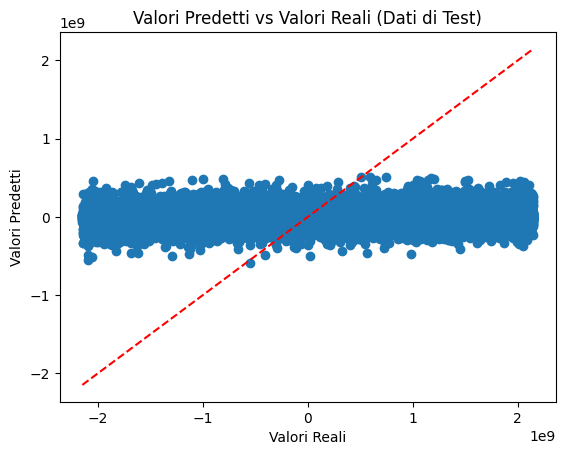

In [137]:
plt.scatter(y_test, y_pred)  # Usa y_test e y_pred per il confronto sui dati di test
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Valori Predetti vs Valori Reali (Dati di Test)')
plt.show()


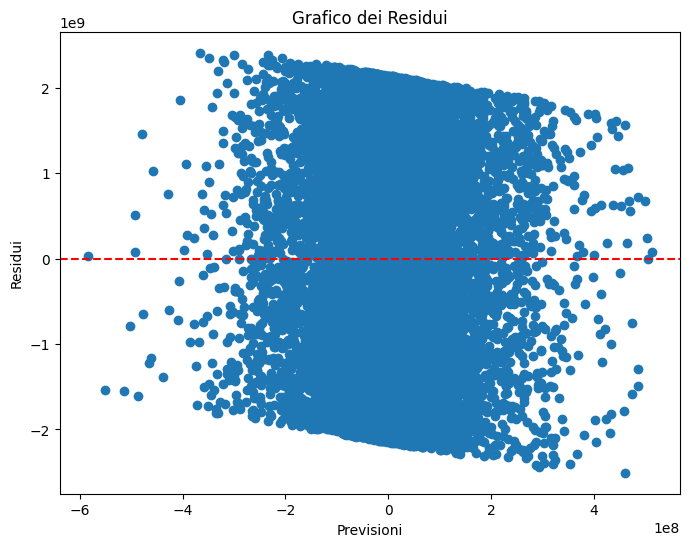

In [130]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Previsioni')
plt.ylabel('Residui')
plt.title('Grafico dei Residui')
plt.show()

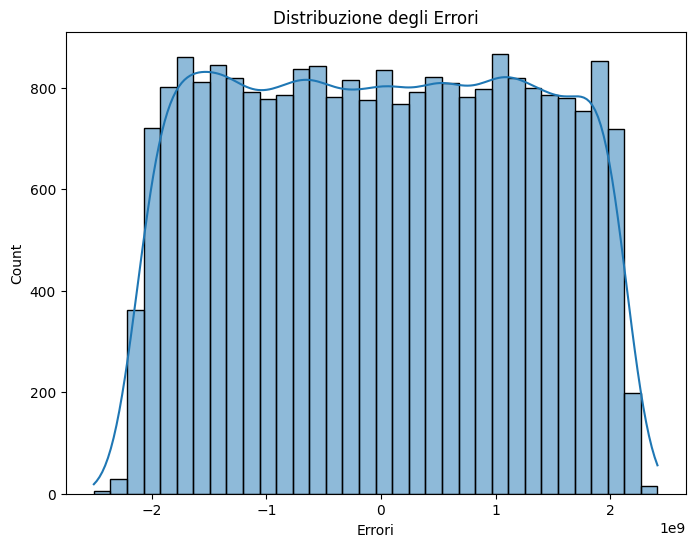

In [131]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Errori')
plt.title('Distribuzione degli Errori')
plt.show()

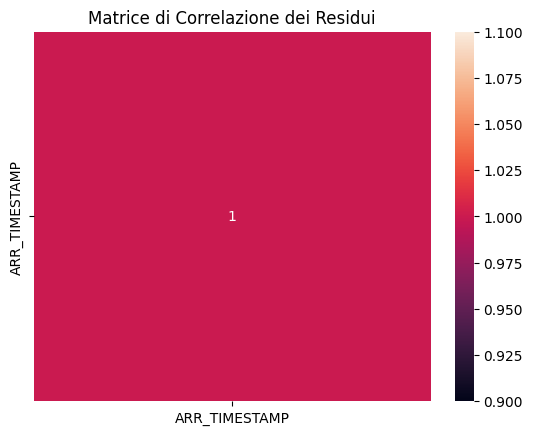

In [132]:
residuals = y_test - y_pred  # Usa y_test invece di y_train
residuals_df = pd.DataFrame(residuals)
correlation_matrix = residuals_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Matrice di Correlazione dei Residui')
plt.show()
